# OCR from scratch

Let's define the problem.

There is an issue with a PDF reader, can latex be interpreted? Nope.

In [438]:
# How to read PDF

import fitz # install using: pip install PyMuPDF
with fitz.open("files/Fisica/fisica.pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()

text[:800]


'Liceo “Carducci” Volterra - Classe 3aB Scientiﬁco - Francesco Daddi - 21 marzo 2011\nEsercizi sul moto circolare uniforme\nEsercizio 1. Un corpo percorre a velocit`a costante una circonferenza di raggio R = 6 m in 8 s. Si determini:\na) il modulo della velocit`a del corpo;\nb) il modulo dell’accelerazione centripeta.\nEsercizio 2. Determinare la velocit`a angolare di un corpo che, muovendosi a velocit`a costante, impiega 39 s per\npercorrere 7 giri e 3/4 su una traiettoria circolare.\nEsercizio 3. a) Calcolare il modulo della velocit`a della Terra nel suo moto attorno al Sole.\nb) Determinare il modulo dell’accelerazione centripeta.\nSi supponga che l’orbita sia perfettamente circolare e il moto uniforme.\nDati: R = 1, 49 · 1011 m ; T = 3, 16 · 107 s.\nEsercizio 4. a) Calcolare il modulo della veloci'

... and there is an issue with Tesseract because we cannot detect latex correctly. Even if we use lang='equ' with the proper [weights](https://tesseract-ocr.github.io/tessdoc/Data-Files#special-data-files)

In [439]:
# https://tesseract-ocr.github.io/tessdoc/Data-Files#special-data-files
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np

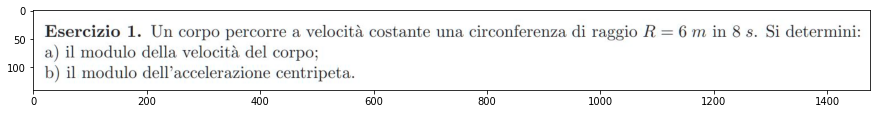

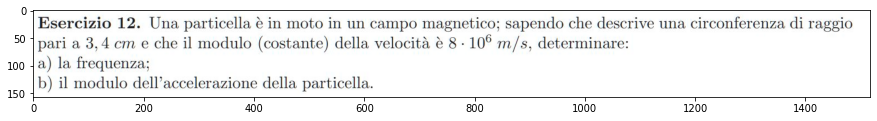

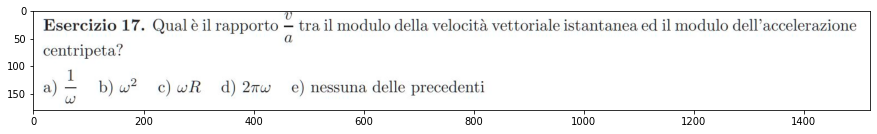

In [440]:
img0 = cv2.imread('files/Fisica/0.jpg')
img1 = cv2.imread('files/Fisica/1.jpg')
img2 = cv2.imread('files/Fisica/2.jpg')

fig = plt.figure(figsize=(15,15))
plt.imshow(img0, cmap='gray')

fig = plt.figure(figsize=(15,15))
plt.imshow(img1, cmap='gray')

fig = plt.figure(figsize=(15,15))
plt.imshow(img2, cmap='gray')

In [441]:
# Print extrated text with tesseract
extracted_text = pytesseract.image_to_string(img0, lang='eng')
print(extracted_text)

extracted_text = pytesseract.image_to_string(img1, lang='eng')
print(extracted_text)

extracted_text = pytesseract.image_to_string(img2, lang='eng')
print(extracted_text)

Esercizio 1. Un corpo percorre a velocita costante una circonferenza di raggio R = 6 m in 8 s. Si determini:
a) il modulo della velocita del corpo;
b) il modulo dell’accelerazione centripeta.

Esercizio 12. Una particella é in moto in un campo magnetico; sapendo che descrive una circonferenza di raggio
pari a 3,4 cm e che il modulo (costante) della velocita @ 8 - 10° m/s, determinare:

a) la frequenza;

b) il modulo dell’accelerazione della particella.

Uv
Esercizio 17. Qual é il rapporto — tra il modulo della velocita vettoriale istantanea ed il modulo dell’accelerazione
a
centripeta?
i

a) — b)w? c)wR 4d) 2zmw  e) nessuna delle precedenti
WwW



Therefore, let's try to build something by us, first of all:
- Convert it to grayscale
- Threshold it using Otsu’s thresholding method

Links not still used but could be useful maybe (?):
- https://medium.com/geekculture/building-a-complete-ocr-engine-from-scratch-in-python-be1fd184753b

In [442]:
# Choose an image that you want to process
img = img0

In [443]:
# # Just for test let's try img_dilation, img_erode. At the moment we didn't use them

# # Taking a matrix of size 5 as the kernel
# kernel = np.ones((5,5), np.uint8)

# img_dilation = cv2.dilate(img, np.ones((1,3), np.uint8), iterations=1)
# fig = plt.figure(figsize=(15,15))
# plt.imshow(img_dilation, cmap='gray')

# img_erode = cv2.erode(img, kernel, iterations=1)

# fig = plt.figure(figsize=(15,15))
# plt.imshow(img_erode, cmap='gray')

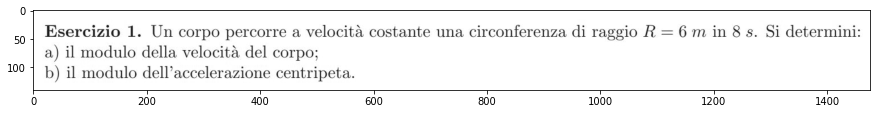

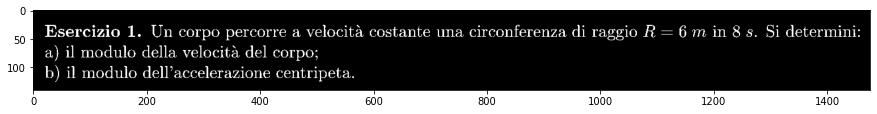

In [444]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(15,15))
plt.imshow(gray, cmap='gray')

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
fig = plt.figure(figsize=(15,15))
plt.imshow(thresh, cmap='gray')

In [445]:
# Let's check if thres 0 values and 1 values cover all the images
a = thresh[thresh==0].shape[0]
b = thresh[thresh==255].shape[0]

print(a,b, thresh.mean())

print( (a+b) == (thresh.shape[0] * thresh.shape[1]) )

195808 10832 13.367015098722415
True


Our goal is to apply connected component analysis to filter out these noise regions, leaving us with just the license plate characters.

In [446]:
# apply connected component analysis to the thresholded image
output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S) # or put 8 instead of 4

(numLabels, labels, stats, centroids) = output
(numLabels, stats, centroids) = (numLabels-1, stats[1::,:], centroids[1::,:]) # exclude background point

In [452]:
idxOrder = centroids[:, 1].argsort()
idxOrder

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  35,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  49,  47,  48,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 108, 107, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 119, 120, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156,
       155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

571 26 6 6


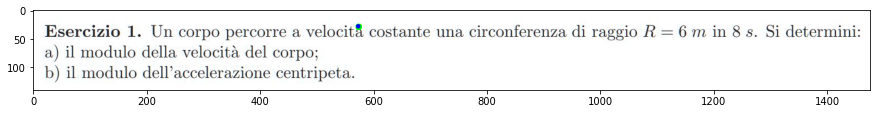

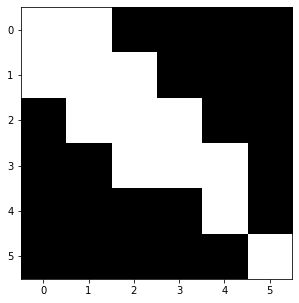

In [453]:
j = 10

output = img.copy()
y = stats[j, cv2.CC_STAT_TOP]
x = stats[j, cv2.CC_STAT_LEFT]
w = stats[j, cv2.CC_STAT_WIDTH]
h = stats[j, cv2.CC_STAT_HEIGHT]
area = stats[j, cv2.CC_STAT_AREA]
(cX, cY) = centroids[j]

# clone our original image (so we can draw on it) and then draw
# a bounding box surrounding the connected component along with
# a circle corresponding to the centroid
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

print(x, y, w, h)

fig = plt.figure(figsize=(15,15))
plt.imshow(output)
plt.show()

fig = plt.figure(figsize=(5,5))
plt.imshow(thresh[y:y+h, x:x+w], cmap="gray")
plt.show()

In [454]:
centroids = centroids[idxOrder]
stats = stats[idxOrder]

area = stats[:, cv2.CC_STAT_AREA]
print(area)
area.mean()

[ 20  10  17   8   8   9   9   9   9   9  13   1 116   9   8  10  61  11
   9  20 195 150  66 105 101 108 108 100 108  57  48  49  47  46  53  47
  47  79  47  47  46  81  61  59  99  55  63  50  50  50  57  59  63 109
  54  54  64  66 101  88  55  68  30  70  69  70  70  99  75  72  67  74
  50  72 120  62  58  61  82  42  81  36  79  71  82  46  32  32  32  32
  43  42  70  80  42  81  52  69  68  98  97  20   2 106 104  21   5   9
   9   8  13   8   9  10   9  68  50  51  52  52  52 112  90  90  58  57
  53  52  58  55  68  65  55  69  69  70 120  65  69  69  41  44  71  60
  59  96  15   9   9   9  16  11  11   9  68  70  70  69  52 105 111  95
  58  49  52  55  49  59  62  55  55  50  63  64  65  70  69  64  66 118
  81  69  77  36  36  32  70  43  60  68  87   5   9]


56.12435233160622

In [455]:
# We are looking for a point that is able to describe a good character for the N-th line
# releated to the area of each char we define a good char the one that has the area greater than the mean of all areas.
def get_good_point(stats):
    area = stats[:, cv2.CC_STAT_AREA]
    areaThres = area.mean()

    for key, val in enumerate(area):
        if val >= areaThres:
            return key

In [456]:
stats[:, cv2.CC_STAT_AREA]

array([ 20,  10,  17,   8,   8,   9,   9,   9,   9,   9,  13,   1, 116,
         9,   8,  10,  61,  11,   9,  20, 195, 150,  66, 105, 101, 108,
       108, 100, 108,  57,  48,  49,  47,  46,  53,  47,  47,  79,  47,
        47,  46,  81,  61,  59,  99,  55,  63,  50,  50,  50,  57,  59,
        63, 109,  54,  54,  64,  66, 101,  88,  55,  68,  30,  70,  69,
        70,  70,  99,  75,  72,  67,  74,  50,  72, 120,  62,  58,  61,
        82,  42,  81,  36,  79,  71,  82,  46,  32,  32,  32,  32,  43,
        42,  70,  80,  42,  81,  52,  69,  68,  98,  97,  20,   2, 106,
       104,  21,   5,   9,   9,   8,  13,   8,   9,  10,   9,  68,  50,
        51,  52,  52,  52, 112,  90,  90,  58,  57,  53,  52,  58,  55,
        68,  65,  55,  69,  69,  70, 120,  65,  69,  69,  41,  44,  71,
        60,  59,  96,  15,   9,   9,   9,  16,  11,  11,   9,  68,  70,
        70,  69,  52, 105, 111,  95,  58,  49,  52,  55,  49,  59,  62,
        55,  55,  50,  63,  64,  65,  70,  69,  64,  66, 118,  8

In [457]:
stats.shape

(193, 5)

This is the line: 1.
ValMin is: 12.
Shape of stats: (193, 5).
This is the line: 1.
Shape of stats: (84, 5).
This is the line: 2.
ValMin is: 6.
Shape of stats: (84, 5).
This is the line: 2.
Shape of stats: (46, 5).
This is the line: 3.
ValMin is: 7.
Shape of stats: (46, 5).
This is the line: 3.
Shape of stats: (0, 5).
The number of detected lines are: 3.


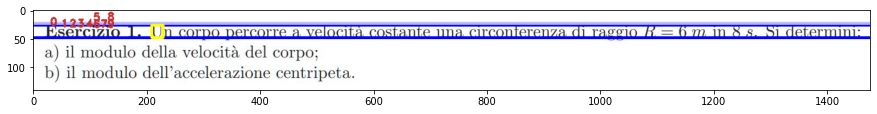

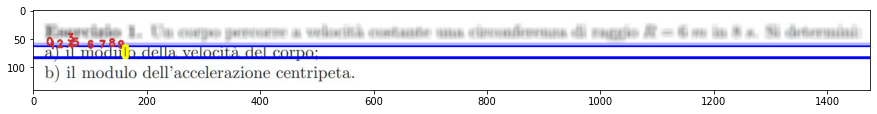

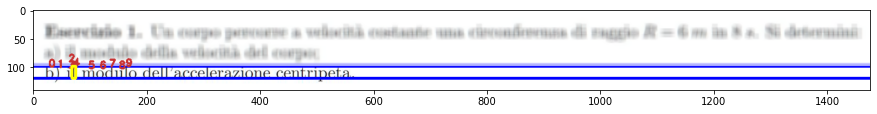

In [458]:
numberLine = 1
centroidsByLine = []
statsByLine = []

while True:

    output = img.copy()

    valMin = get_good_point(stats)


    print(f"This is the line: {numberLine}.")
    print(f"ValMin is: {valMin}.")
    print(f"Shape of stats: {stats.shape}.")
    #print(stats)
    x = stats[valMin, cv2.CC_STAT_LEFT]
    y = stats[valMin, cv2.CC_STAT_TOP]
    w = stats[valMin, cv2.CC_STAT_WIDTH]
    h = stats[valMin, cv2.CC_STAT_HEIGHT]
    area = stats[valMin, cv2.CC_STAT_AREA]

        
    #print(area)
    #cx, cy = centroids[valMin]

    # Top line
    cv2.line(output, (0, y), (output.shape[1], y), (0, 0, 255), thickness=3)
    output[:y,:,:] = cv2.blur(output[:y,:,:], (10,10))

    # Bottom Line
    cv2.line(output, (0, y + h), (output.shape[1], y + h), (0, 0, 255), thickness=3)

    # Get index of all centroids that are above the bottom line
    idxMask = centroids[:,1]>(y + h)

    # Order index of the N-th line from left to right
    invertedIdx = np.invert(idxMask)
    centroidsOfThatLine = centroids[invertedIdx]
    statsOfThatLine = stats[invertedIdx]

    # Sort by x component
    idxOrder = centroidsOfThatLine[:, 0].argsort()

    centroidsOfThatLine = centroidsOfThatLine[idxOrder]
    statsOfThatLine = statsOfThatLine[idxOrder]

    centroidsByLine.append(centroidsOfThatLine)
    statsByLine.append(statsOfThatLine)

    # Print only some centroids, not all. Try/except because centroids can be out the image..., this is only to have some visuals
    try:
        for i in range(10):
            (cX, cY) = centroidsOfThatLine[i]
            cv2.putText(output, f"{i}", (int(cX), int(cY)-10), cv2.FONT_HERSHEY_DUPLEX, 0.6, (200, 50, 50), 2)
    except Exception as e:
        print(e)

    # Focus the char used to identify the line
    cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 0), 3)

    fig = plt.figure(figsize=(15,15))
    plt.imshow(output)
    
    centroids = centroids[idxMask]
    stats = stats[idxMask]
    print(f"This is the line: {numberLine}.")
    print(f"Shape of stats: {stats.shape}.")
    #print(stats)

    if centroids.shape[0] < 1:
        break

    numberLine+=1

print(f"The number of detected lines are: {numberLine}.")

In [459]:
from IPython.display import clear_output
import time 

In [460]:
def printChar(i, j):

    centroids = centroidsByLine[i]
    nrows, ncols = centroids.shape
    stats = statsByLine[i]

    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output = img.copy()

    # print a status message update for the current connected component
    text = f"Examining row {i+1} and component {j}/{nrows}."
    print(f"[INFO] {text}")
    
    # extract the connected component statistics and centroid for
    # the current label
    y = stats[j, cv2.CC_STAT_TOP]
    x = stats[j, cv2.CC_STAT_LEFT]
    w = stats[j, cv2.CC_STAT_WIDTH]
    h = stats[j, cv2.CC_STAT_HEIGHT]
    area = stats[j, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[j]
    print(f"Area={area}")
    print(f"Centroids {cX}, {cY}")
    print(f"y={y}, x={x}, w={w}, h={h}")

    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

    # show our output image and connected component mask
    fig = plt.figure(figsize=(15,15))
    plt.imshow(output)
    plt.show()

    fig = plt.figure(figsize=(5,5))
    plt.imshow(thresh[y:y+h, x:x+w], cmap="gray")
    plt.show()

[INFO] Examining row 1 and component 15/109.
Area=50
Centroids 262.16, 39.48
y=33, x=258, w=11, h=14


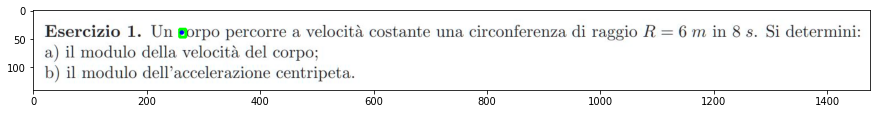

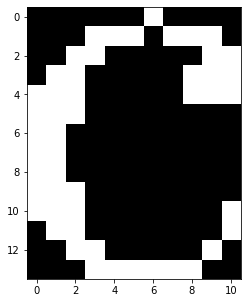

In [461]:
printChar(0, 15)

In [462]:
# Print all chars, set "if True" to execute

if False:
    for i in range(len(centroidsByLine)):
        for j in range(centroidsByLine[i].shape[0]):

            printChar(i, j)

            time.sleep(0.1)
            clear_output(wait=True)
    

Ok, now we have to think a way to merge, remove or change things between 2 adjacent lines.

For instance:
- "i" char is detected as two values (a vertical line and a point above that), therefore we need to merge in a unique value.
- Accents sometimes are detected in a different line, but regardless this is important to join in a unique value
- fractions are another point important to treat


Ok, now we examinate if there is a way to merge accents and the point above the i chars. Using img0

[INFO] Examining row 1 and component 39/109.
Area=10
Centroids 571.1, 35.4
y=34, x=570, w=4, h=4


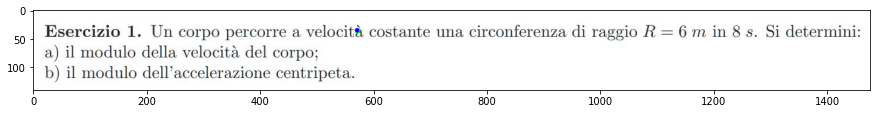

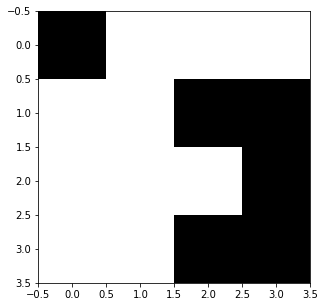

[INFO] Examining row 1 and component 40/109.
Area=13
Centroids 573.1538461538462, 28.076923076923077
y=26, x=571, w=6, h=6


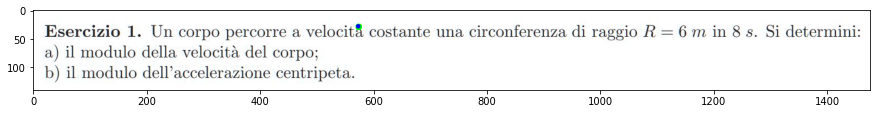

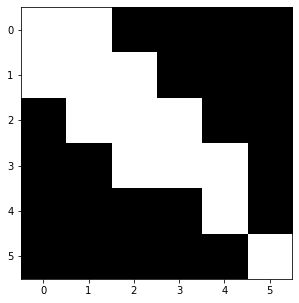

[INFO] Examining row 1 and component 41/109.
Area=69
Centroids 575.6521739130435, 41.42028985507246
y=34, x=569, w=14, h=13


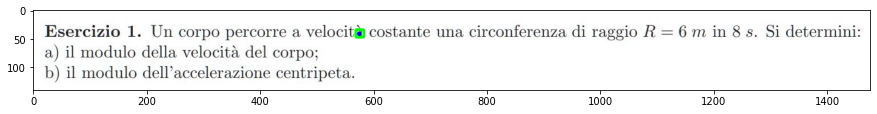

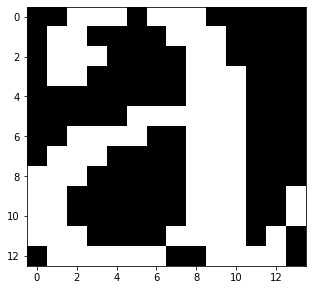

In [463]:
# i-th line, j-char

# img 0
# accents problem
printChar(0, 39)
printChar(0, 40)
printChar(0, 41)

[INFO] Examining row 1 and component 5/109.
Area=17
Centroids 106.6470588235294, 28.0
y=26, x=105, w=5, h=5


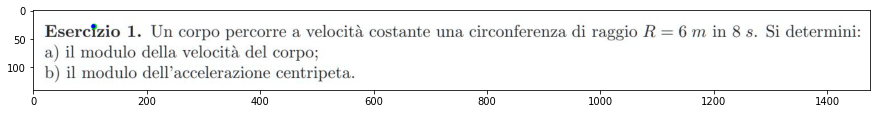

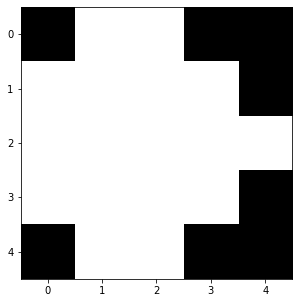

[INFO] Examining row 1 and component 6/109.
Area=50
Centroids 106.88, 40.06
y=33, x=104, w=7, h=14


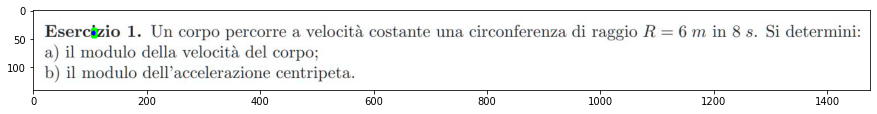

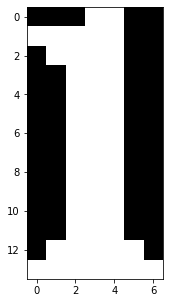

[INFO] Examining row 1 and component 36/109.
Area=9
Centroids 551.0, 28.0
y=27, x=550, w=3, h=3


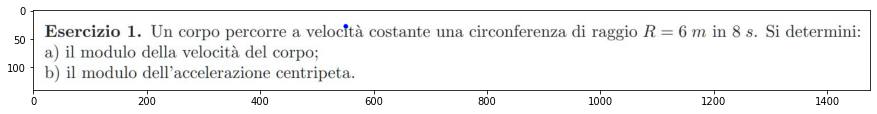

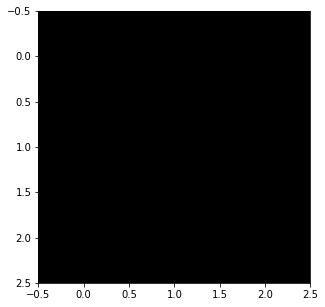

[INFO] Examining row 1 and component 37/109.
Area=32
Centroids 551.375, 40.375
y=34, x=549, w=6, h=13


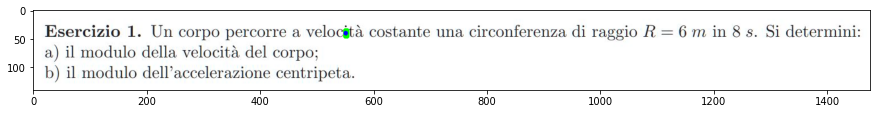

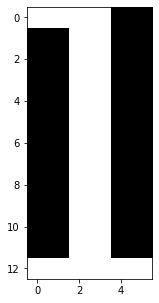

In [464]:
# i-th line, j-char

# img 0
# "i" problem

printChar(0, 5)
printChar(0, 6)

printChar(0, 36)
printChar(0, 37)

[INFO] Examining row 1 and component 34/109.
Area=43
Centroids 538.6046511627907, 40.395348837209305
y=33, x=535, w=12, h=14


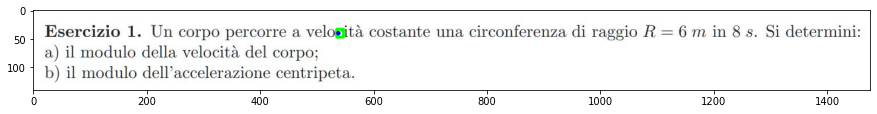

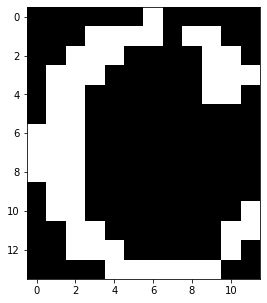

[INFO] Examining row 1 and component 35/109.
Area=9
Centroids 544.4444444444445, 35.55555555555556
y=34, x=543, w=4, h=4


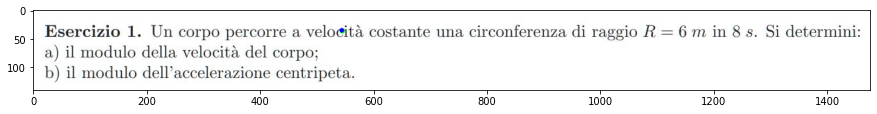

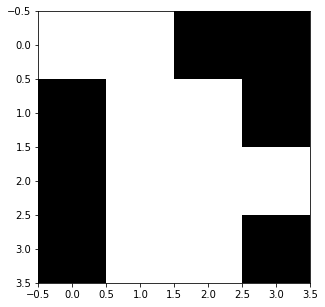

In [465]:
# i-th line, j-char

# img 0
# c problem

printChar(0, 34)
printChar(0, 35)


[INFO] Examining row 1 and component 44/109.
Area=52
Centroids 626.0384615384615, 41.30769230769231
y=34, x=622, w=10, h=13


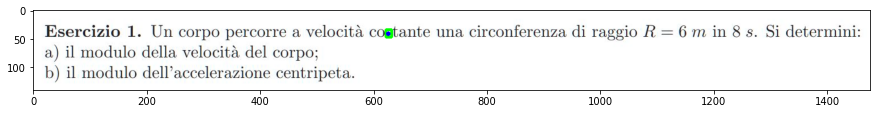

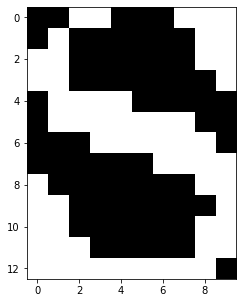

[INFO] Examining row 1 and component 45/109.
Area=1
Centroids 627.0, 33.0
y=33, x=627, w=1, h=1


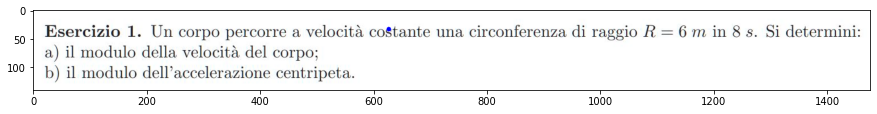

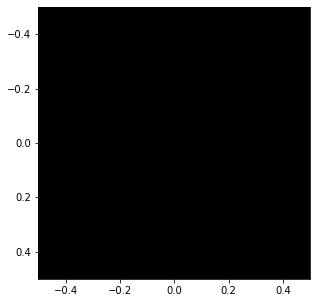

[INFO] Examining row 1 and component 46/109.
Area=8
Centroids 630.375, 35.125
y=34, x=629, w=3, h=4


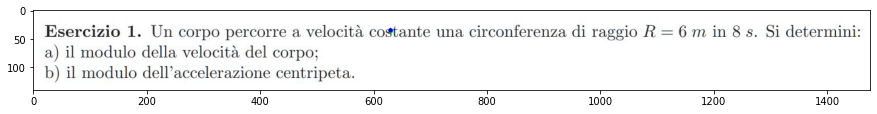

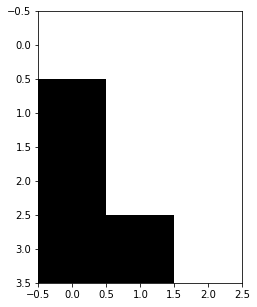

In [466]:
# i-th line, j-char

# img 0
# s problem

printChar(0, 44)
printChar(0, 45)
printChar(0, 46)

In [467]:
def printAllCharsAsPoint():
    output = img.copy()

    for i in range(len(centroidsByLine)):

        for j in range(centroidsByLine[i].shape[0]):
            
            xCurrent = centroidsByLine[i][j][0]
            yCurrent = centroidsByLine[i][j][1]

            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

In [468]:
# Let's see the shapes before the process
centroidsByLine[0].shape

(109, 2)

Backward pass

Merge the i-th char with the previous one if:

current_centroids_x - width/2 < current_centroids_x < current_centroids_x + width/2

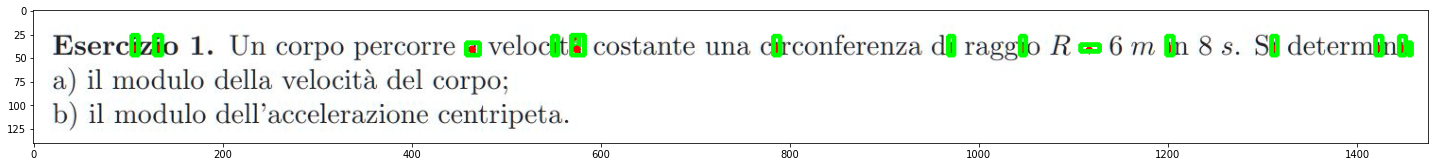

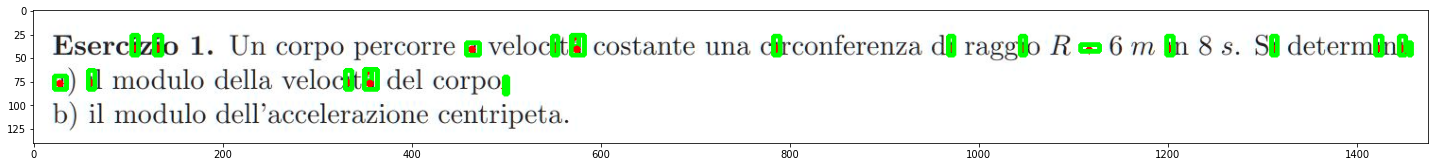

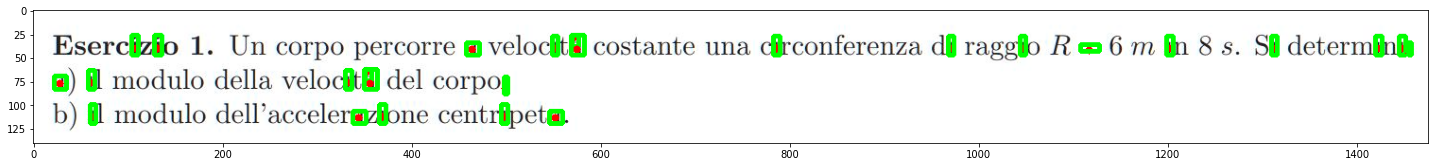

In [469]:
output = img.copy()

for i in range(len(centroidsByLine)):

    centroidsByLineNew = [centroidsByLine[i][0].tolist()]
    statsByLineNew = [statsByLine[i][0].tolist()]

    for j in range(1, centroidsByLine[i].shape[0]):
        
        xPrevious = centroidsByLine[i][j-1][0]
        yPrevious = centroidsByLine[i][j-1][1]
        xCurrent = centroidsByLine[i][j][0]
        yCurrent = centroidsByLine[i][j][1]
        width = statsByLine[i][j][cv2.CC_STAT_WIDTH] / 2

        if xCurrent-width <= xPrevious <= xCurrent+width:
            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

            # Merge current and old chars
            yPrevious = statsByLineNew[-1][cv2.CC_STAT_TOP]
            xPrevious = statsByLineNew[-1][cv2.CC_STAT_LEFT]
            yCurrent = statsByLine[i][j][cv2.CC_STAT_TOP]
            xCurrent = statsByLine[i][j][cv2.CC_STAT_LEFT]
            widthPrevious = statsByLineNew[-1][cv2.CC_STAT_WIDTH]
            heightPreivous = statsByLineNew[-1][cv2.CC_STAT_HEIGHT]
            widthCurrent = statsByLine[i][j][cv2.CC_STAT_WIDTH]
            heightCurrent = statsByLine[i][j][cv2.CC_STAT_HEIGHT]

            x = min(xPrevious, xCurrent)
            y = min(yPrevious, yCurrent)

            widthNew = int( max(xPrevious+widthPrevious, xCurrent+widthCurrent) - x )
            heightNew = int( max(yPrevious+heightPreivous, yCurrent+heightCurrent) - y )

            centre = [x + widthNew/2, y + heightNew/2]

            cv2.rectangle(output, (int(x), int(y)), (int(x + widthNew), int(y + heightNew)), (0, 255, 0), 3)

            # Remove the previous point from the lists and append new values
            centroidsByLineNew = centroidsByLineNew[:-1]
            centroidsByLineNew.append(centre)
            statsByLineNew = statsByLineNew[:-1]
            statsByLineNew.append([x,y,widthNew,heightNew, widthNew*heightNew])
            
        else:
            centroidsByLineNew.append(centroidsByLine[i][j].tolist())
            statsByLineNew.append(statsByLine[i][j].tolist())

    # Assign the new list to the i-th line, obviously as numpy object
    centroidsByLine[i] = np.array(centroidsByLineNew)
    statsByLine[i] = np.array(statsByLineNew)

    # Show results
    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

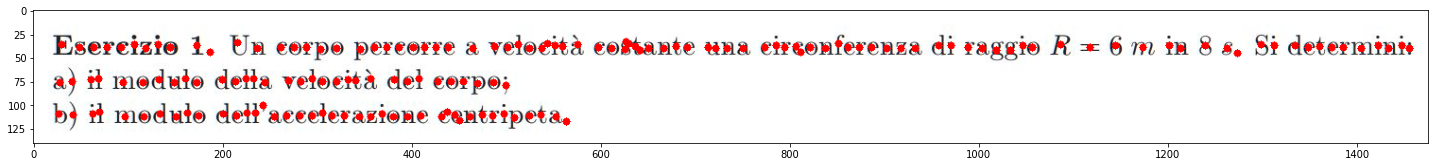

In [470]:
printAllCharsAsPoint()

In [471]:
# Let's see the intermediate level
centroidsByLine[0].shape

(94, 2)

Let's try to see if there are other problems

[INFO] Examining row 1 and component 38/94.
Area=52
Centroids 626.0384615384615, 41.30769230769231
y=34, x=622, w=10, h=13


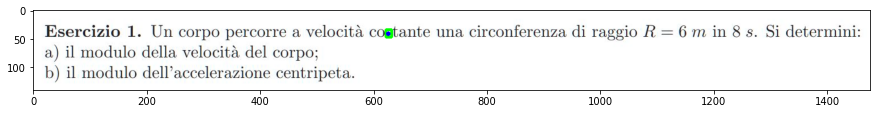

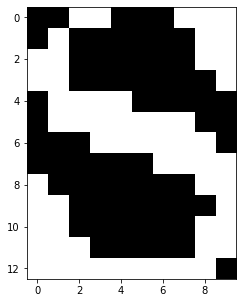

[INFO] Examining row 1 and component 39/94.
Area=1
Centroids 627.0, 33.0
y=33, x=627, w=1, h=1


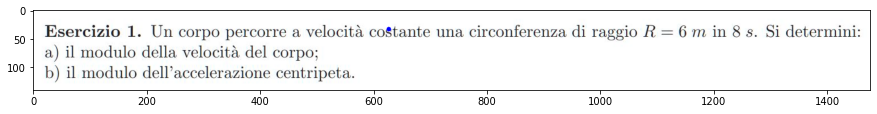

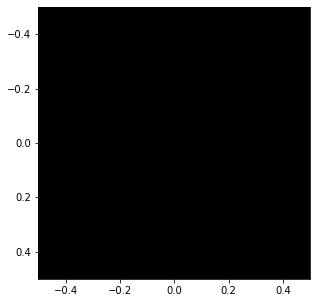

[INFO] Examining row 1 and component 40/94.
Area=8
Centroids 630.375, 35.125
y=34, x=629, w=3, h=4


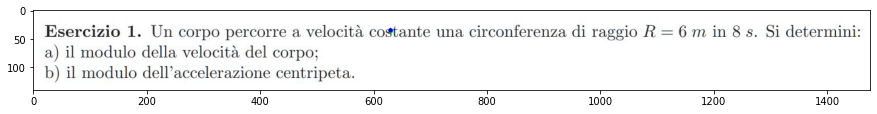

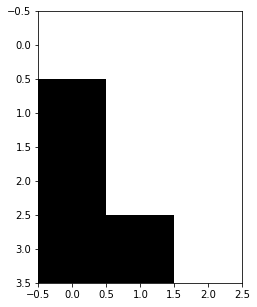

In [472]:
printChar(0, 38)
printChar(0, 39)
printChar(0, 40)

Forward pass

Merge the i-th char with the next one if:

WE NEED TO FIX THIS


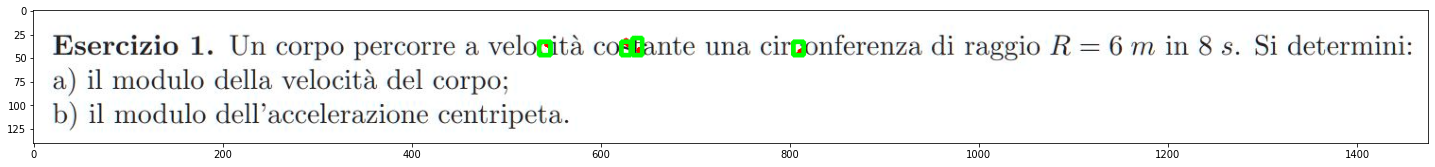

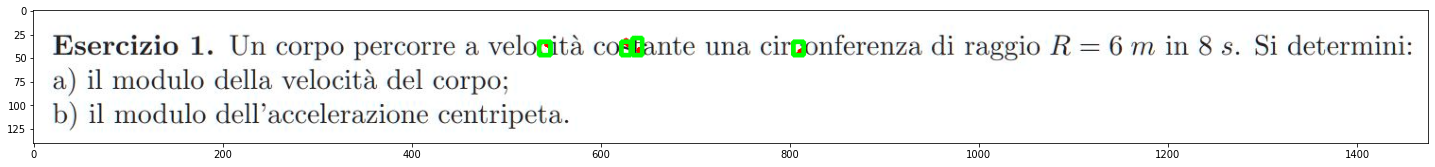

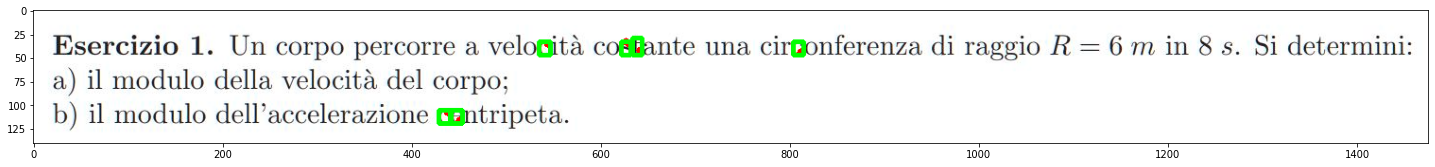

In [473]:
output = img.copy()

for i in range(len(centroidsByLine)):

    centroidsByLineNew = [centroidsByLine[i][0].tolist()]
    statsByLineNew = [statsByLine[i][0].tolist()]

    for j in range(1, centroidsByLine[i].shape[0]):
        
        xPrevious = centroidsByLine[i][j-1][0]
        yPrevious = centroidsByLine[i][j-1][1]
        xCurrent = centroidsByLine[i][j][0]
        yCurrent = centroidsByLine[i][j][1]
        width = statsByLine[i][j-1][cv2.CC_STAT_WIDTH] / 2

        if xPrevious-width-3 <= xCurrent <= xPrevious+width+3: # ATTENTION, YOU USED -3 AND +3, BUT ARE EURISTIC...
            cv2.circle(output, (int(xCurrent), int(yCurrent)), 4, (255, 0, 0), -1)

            # Merge current and old chars
            yPrevious = statsByLineNew[-1][cv2.CC_STAT_TOP]
            xPrevious = statsByLineNew[-1][cv2.CC_STAT_LEFT]
            yCurrent = statsByLine[i][j][cv2.CC_STAT_TOP]
            xCurrent = statsByLine[i][j][cv2.CC_STAT_LEFT]
            widthPrevious = statsByLineNew[-1][cv2.CC_STAT_WIDTH]
            heightPreivous = statsByLineNew[-1][cv2.CC_STAT_HEIGHT]
            widthCurrent = statsByLine[i][j][cv2.CC_STAT_WIDTH]
            heightCurrent = statsByLine[i][j][cv2.CC_STAT_HEIGHT]

            x = min(xPrevious, xCurrent)
            y = min(yPrevious, yCurrent)

            widthNew = int( max(xPrevious+widthPrevious, xCurrent+widthCurrent) - x )
            heightNew = int( max(yPrevious+heightPreivous, yCurrent+heightCurrent) - y )

            centre = [x + widthNew/2, y + heightNew/2]

            cv2.rectangle(output, (int(x), int(y)), (int(x + widthNew), int(y + heightNew)), (0, 255, 0), 3)

            # Remove the previous point from the lists and append new values
            centroidsByLineNew = centroidsByLineNew[:-1]
            centroidsByLineNew.append(centre)
            statsByLineNew = statsByLineNew[:-1]
            statsByLineNew.append([x,y,widthNew,heightNew, widthNew*heightNew])
            
        else:
            centroidsByLineNew.append(centroidsByLine[i][j].tolist())
            statsByLineNew.append(statsByLine[i][j].tolist())

    # Assign the new list to the i-th line, obviously as numpy object
    centroidsByLine[i] = np.array(centroidsByLineNew)
    statsByLine[i] = np.array(statsByLineNew)

    # Show results
    fig = plt.figure(figsize=(25,25))
    plt.imshow(output, cmap="gray")
    plt.show()

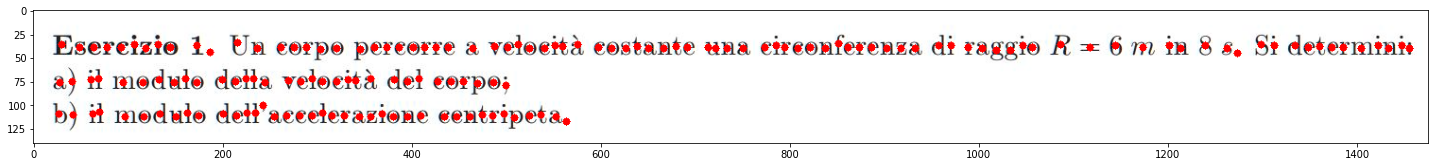

In [474]:
printAllCharsAsPoint()

In [475]:
centroidsByLine[0].shape

(89, 2)

Let's try to find the group of words

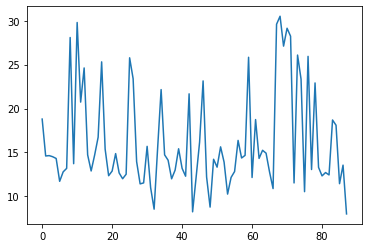

In [476]:
# Get distances between chars using centroids
dist = np.diff(centroidsByLine[0], axis=0)[:,0]

plt.plot(np.abs(dist))

Mmm, with the previous method there is too noise

In [477]:
# Let's try somenthing better using stat_left and right
# Get distances between chars. 
# i is the i-th line

def getDistChars(i):
    right = (statsByLine[i][:,0] + statsByLine[i][:,2])[:-1]
    dist = np.abs( right - statsByLine[i][1:,0] )
    
    return dist, right

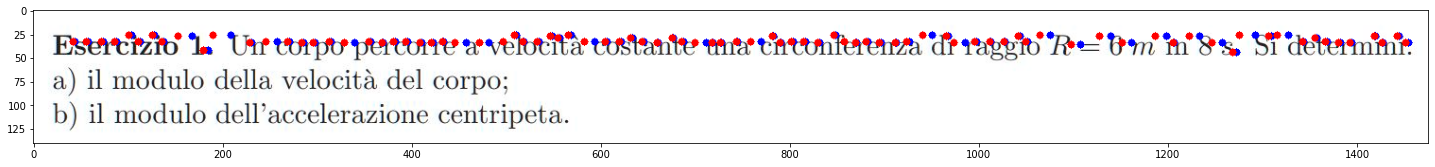

In [478]:
# Let's see what we actually comparing during the process

output = img.copy()

dist, right = getDistChars(0)

for i, val in enumerate(statsByLine[0][1:]):
    x = val[cv2.CC_STAT_TOP]
    y = val[cv2.CC_STAT_LEFT]
    cv2.circle(output, (y, x), 4, (0, 0, 255), -1) # blue

    yn = right[i]
    cv2.circle(output, (yn, x), 4, (255, 0, 0), -1) #red

    #print(yn-y)

fig = plt.figure(figsize=(25,25))
plt.imshow(output, cmap="gray")
plt.show()

5.0


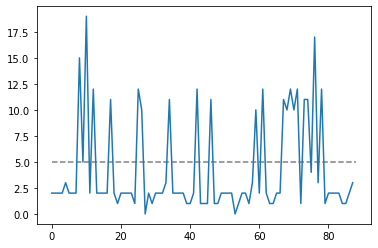

In [479]:
# Print mean value of the first line
def computeAutoThresh(dist):
    if dist.shape[0] != 0:
        autoThresh = np.ceil(dist.mean())
        print(autoThresh)
        plt.hlines(y=autoThresh, xmin=0, xmax=len(dist), colors='gray', linestyles='--')
        plt.plot(dist)
        plt.show()
        return autoThresh
    else:
        return dist[0]

autoThresh = computeAutoThresh(dist)

5.0


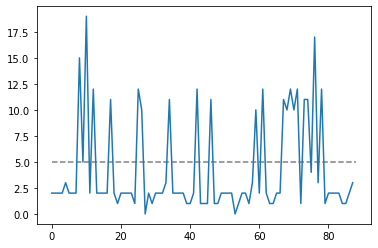

4.0


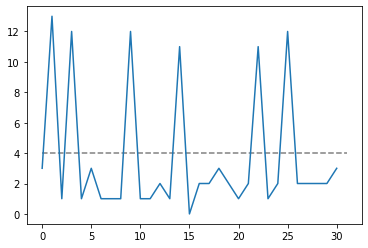

3.0


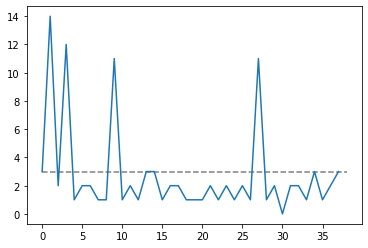

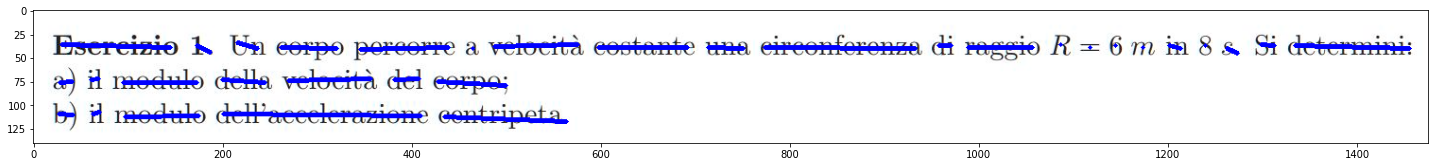

In [480]:
output = img.copy()

for j in range(len(centroidsByLine)):
    startP = centroidsByLine[j][0]

    dist, right = getDistChars(j)

    if dist.shape[0] != 0:
        autoThresh = computeAutoThresh(dist)       

        for i, val in enumerate(dist):

            if val > autoThresh:
                cv2.line(output, (int(startP[0]), int(startP[1])), ( int(centroidsByLine[j][i][0]), int(centroidsByLine[j][i][1])), (0, 0, 255), thickness=3)
                startP = centroidsByLine[j][i+1]

        cv2.line(output, (int(startP[0]), int(startP[1])), ( int(centroidsByLine[j][-1][0]), int(centroidsByLine[j][-1][1])), (0, 0, 255), thickness=3)

    else:
        cv2.circle(output, (int(startP[0]), int(startP[1])), 4, (0, 0, 255), -1) # blue

fig = plt.figure(figsize=(25,25))
plt.imshow(output, cmap="gray")
plt.show()